In [1]:
import pandas as pd

#load the data.
df = pd.read_csv("./data/train3.csv")

In [2]:
df.shape

(56000, 3)

In [3]:
df.head()

,Text,Class,ID
0,Fun little place to stop and have lunch There...,positive,1307144
1,This place was PACKED Went for late night foo...,negative,5544361
2,We board the plane 30 minutes before the actua...,positive,5956200
3,Chaotic 4 story place but fun for kids The w...,positive,718388
4,After (intentionally) capsizing a sailboat in ...,neutral,174754


In [4]:
from random import randint

#number of texts to print.
num_sample = 10
#to store random integers in range [0, len(df)].
rand = []
#generate random integers.
for _ in range(num_sample):
    value = randint(0, len(df))
    if value not in rand:
        rand.append(value)

#print out the texts at random index computed above.
for rand_index in rand:
    print(df['Text'][rand_index], end='\n\n')

Have been coming to Fresh on Bloor for years and its easily my favourite of the four Fresh Restaurants in Toronto  Every time I visit Im met with exceptional service  and great food  Ive never had a disappointing visit to Fresh on Bloor and I visit whenever Im in the area 

We checked out The Teapot today  it has only been open for three weeks  and it is just adorable! A family friendly place that serves coffee and tea with a quaint backyard that has a play area for the littles to play while us mommas get our coffee fix! Such a great idea  We will definitely be back!

Very fast service with friendly wait staff  albeit always looking just a little bit stressed out Moments after you sit you get a salad with Thai sweet dressing  as well as a menu  Pretty good selection for a small place  Been happy with every dish Ive had so far  Fast  Great food  Plentiful portions  My go to spot for lunch 

My husband only lets us watch movies here  there snacks are great  you pick your seat and lounge 

In [5]:
#class distribution.
df['Class'].value_counts()

positive    38348
negative    11897
neutral      5755
Name: Class, dtype: int64

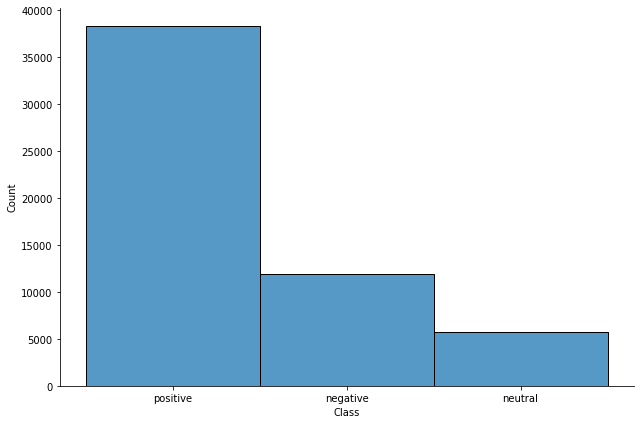

In [7]:
import seaborn as sns

sns.displot(df['Class'], bins=10, height=6, aspect=1.5)

In [8]:
#dictionary of distinct labels.
possible_labels = df['Class'].unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print("Labels' dictionary: %s" % label_dict)

#convert nomial to numeric.
df['Class'] = df['Class'].replace(label_dict)

Labels' dictionary: {'positive': 0, 'negative': 1, 'neutral': 2}


In [9]:
import re 

#a dictionary of contractions.
dict = {'isnt': 'is not',
        'arent': 'are not',
        'wasnt': 'was not',
        'werent': 'were not',
        'cant': 'can not',
        'dont': 'do not',
        'didnt': 'did not',
        'wont': 'will not',
        'wouldnt': 'would not',
        'couldnt': 'could not',
        'havent': 'have not',
        'hasnt': 'has not'}

#process function.
def preprocess_text(s):
    #convert to lower case.
    s = s.casefold()
    #remove punctuations and number.
    s = re.sub(r'[^a-zA-Z]', ' ', s)
    #remove single char.
    s = re.sub(r'\s+[a-zA-Z]\s+', ' ', s)
    #remove multiple spaces.
    s = re.sub(r'\s+', ' ', s)
    #remove extra spaces.
    s = s.strip()
    #remove contraction.
    for key, value in dict.items():
        s = re.sub(key, value, s)
    return s

In [10]:
#apply preprocessing on the dataset.
df['Text'] = df['Text'].apply(lambda x : preprocess_text(x))

In [11]:
df.head()

,Text,Class,ID
0,fun little place to stop and have lunch there ...,0,1307144
1,this place was packed went for late night food...,1,5544361
2,we board the plane minutes before the actual f...,0,5956200
3,chaotic story place but fun for kids the white...,0,718388
4,after intentionally capsizing sailboat in ttl ...,2,174754


In [12]:
from sklearn.model_selection import train_test_split

#split data into train and test.
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df['Class'].values,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify = df['Class'].values, #keep the class distribution.
                                                  random_state=42)

In [13]:
#add datatype column.
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [14]:
from transformers import BertTokenizer, BertForSequenceClassification

model_name = 'bert-base-uncased'
#tokenizer and model.
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:
#store the length of all the reviews in the dataset. 
train_len = []
#store the text with the maximum length in the dataset.
max_len = 0
for _, text in enumerate(df['Text']):
    train_len.append(len(tokenizer(text)['input_ids']))
    if len(tokenizer(text)['input_ids']) > max_len:
        max_len = len(tokenizer(text)['input_ids'])
print(max_len)

235


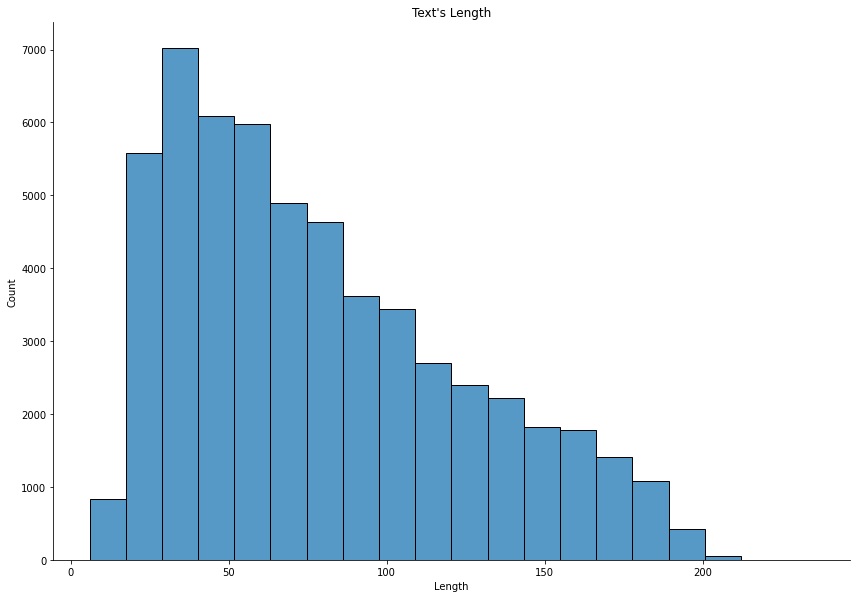

In [16]:
import seaborn as sns

#reviews' length in the dataset.
ax = sns.displot(data=train_len, bins=20, height=8, aspect=1.5) #assign result to new axis variable.
ax.set(xlabel="Length", ylabel = "Count", title="Text's Length") #call .set() with this new variable to set x/ylabel.

In [17]:
#encoder.
def encoder(texts, tokenizer):
    """Compute encodings given texts and a tokenizer."""
    encodings = tokenizer.batch_encode_plus(texts,
                                            return_token_type_ids=False, #no need for this task.
                                            #truncation=True, #all sentences are shorter than model's max length (512), no need to truncate. 
                                            padding='max_length',
                                            max_length=300, #since max_len is 235, we'll pad everything to 300.
                                            return_tensors='pt')
    return encodings

In [18]:
import torch 

#encode and add labels to the training data.
train_encodings = encoder(df[df.data_type=='train'].Text.values, tokenizer)
train_encodings['labels'] = torch.tensor(df[df.data_type=='train'].Class.values)

#encode and add labels to the validation data.
val_encodings = encoder(df[df.data_type=='val'].Text.values, tokenizer)
val_encodings['labels'] = torch.tensor(df[df.data_type=='val'].Class.values)

In [19]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def accuracy_score_func(preds, labels):
    """Calculate accuracy given predictions and labels."""
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(preds_flat, labels_flat)

def f1_score_func(preds, labels):
    """Calculate weighted f1 score given predictions and labels."""
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(preds_flat, labels_flat, average='weighted')

In [21]:
from tqdm import tqdm

def evaluate(model, val_dataloader):
    """Return loss, predictions and true values on validation dataset."""
    #evaluation mode.
    model.eval()

    #store variables.
    loss_val_total = 0 #total loss.
    predictions, true_vals = [], [] #predicted labels and real labels.

    for batch in tqdm(val_dataloader):

        #load into device.
        batch = tuple(b.to(device) for b in batch)

        #define inputs.
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute outputs.
        with torch.no_grad():
            outputs = model(**inputs)

        #save loss and logits.
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #store predictions and labels.
        logits = logits.cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    #compute average loss.
    loss_val_avg = loss_val_total / len(val_dataloader)

    #flatten predictions and true_vals arrays.
    predictions = np.concatenate(predictions)
    true_vals = np.concatenate(true_vals)

    return loss_val_avg, predictions, true_vals

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import AdamW, get_linear_schedule_with_warmup

train_dataset = TensorDataset(train_encodings['input_ids'], 
                              train_encodings['attention_mask'], 
                              train_encodings['labels'])
val_dataset = TensorDataset(val_encodings['input_ids'], 
                            val_encodings['attention_mask'], 
                            val_encodings['labels'])

batch_size = 8

#create loader for training data.
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)
#create loader for validating data.
val_dataloader = DataLoader(val_dataset,
                            sampler=RandomSampler(val_dataset),
                            batch_size=batch_size)

#set up optimizer and scheduler for fine-tuning model.
optimizer = AdamW(model.parameters(),
                  lr=3e-5,
                  eps=1e-8)
epochs = 3
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*epochs)

In [23]:
import os

#check for available gpu.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
#move the model to the available device.
model.to(device)

#fine-tune the model.
for epoch in range(1, epochs+1):

    #training mode.
    model.train()

    #setting initial loss to 0.
    loss_train_total = 0

    #setting up the progress bar.
    progress_bar = tqdm(train_dataloader,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        #set gradient to 0.
        model.zero_grad()

        #the batch will be a tuple of 3.
        batch = tuple(b.to(device) for b in batch)

        #dictionary of inputs.
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #unpack the dict straight into inputs.
        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        #gradient clipping.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
    #check if path exists.
    if not os.path.exists('models'):
        os.mkdir('models')
    torch.save(model.state_dict(), f'models/Bert_sa_ft_epoch{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_ave = loss_train_total / len(train_dataloader)
    tqdm.write(f'Training loss: {loss_train_ave}')

    val_loss, predictions, true_vals = evaluate(model, val_dataloader)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = accuracy_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 2070 Super



Epoch 1
Training loss: 0.36587241202678084


100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [02:24<00:00,  9.68it/s]


Validation loss: 0.3385196447698399
Validation accuracy: 0.8927678571428571
F1 Score (weighted): 0.8987307323307425



Epoch 2
Training loss: 0.2611881009049362


100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [02:29<00:00,  9.40it/s]


Validation loss: 0.3538742558809463
Validation accuracy: 0.8859821428571428
F1 Score (weighted): 0.8836522345871873



Epoch 3
Training loss: 0.16792213858643923


100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [02:26<00:00,  9.53it/s]

Validation loss: 0.5001744945624419
Validation accuracy: 0.8908928571428572
F1 Score (weighted): 0.8929451733553864
